# Neural network from scratch


This project creates a neural network from scratch using Numpy. The neural network will contain two inputs, one output, and a single hidden layer with three neurons, as shown below. The purpose of this project was to help me fully understand the mathematics of neural networks and how to translate it into code without recourse to ML libraries. (A subsequent project will construct a more elaborate convolutional neural network using Pytorch.)

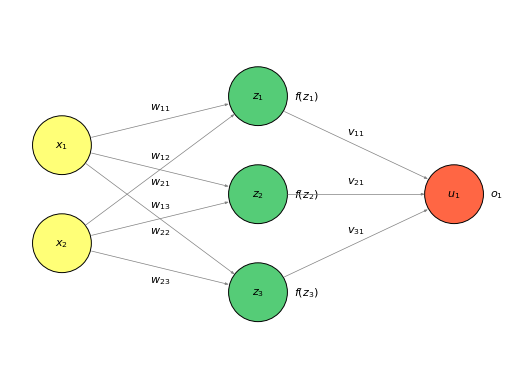

In [1]:
#!pip install viznet
import matplotlib.pyplot as plt
import numpy as np
import viznet
from viznet import NodeBrush, EdgeBrush

brush1 = NodeBrush('nn.input', size='normal')
brush2 = NodeBrush('nn.hidden', size='normal')
brush3 = NodeBrush('nn.output', size='normal')
edge = EdgeBrush('->', lw=0.5, zorder=1000, color='grey')
neuron_counts = [2,3,1] # The number of neurons per layer
x = []
z = []
u = []
w, v = [], []
for i in range(neuron_counts[0]):
    x.append(brush1 >> (1,1.5-i))
    x[i].text('$x_' + str(i + 1) +'$', 'center', fontsize=8)

for j in range(neuron_counts[1]):
    z.append(brush2 >> (3, 2-j))
    z[j].text(f'$z_{j+1}$', 'center', fontsize=8)
    z[j].text(f'$f(z_{j+1})$', 'right', fontsize=8)
    for i in range(neuron_counts[0]):
        pos = 'top' if i%2 == 0 else 'bottom'
        w.append(edge >> (x[i], z[j]))
        w[-1].text(f'$w_{{{i+1}{j+1}}}$', pos, fontsize=8)
for k in range(neuron_counts[2]):
    u.append(brush3 >> (5, 1-k))
    u[k].text(f'$u_{k+1}$', fontsize=8)
    u[k].text(f'$o_{k+1}$', 'right', fontsize=8)
    for j in range(neuron_counts[1]):
        v.append(edge >> (z[j], u[k]))
        v[-1].text(f'$v_{{{j+1}{k+1}}}$', 'top', fontsize=8)
plt.axis('off')
plt.axis('equal')
plt.show()

#### Activation function
I first create activation functions for the neurons and derivatives for these functions (for back propagation). I will use ReLU for the hidden layers and an identity function for the output function.

$f(z) = max(z, 0)$

$f(u) = u$

In [3]:
import numpy as np
def rectified_linear_unit(x):
    """ Returns the ReLU of x, or the maximum between 0 and x."""
    return max(0, x)

def rectified_linear_unit_derivative(x):
    """ Returns the derivative of ReLU."""
    return 1 if x > 0 else 0

def output_layer_activation(x):
    """ Linear function, returns input as is. """
    return x

def output_layer_activation_derivative(x):
    """ Returns the derivative of a linear function: 1. """
    return 1

#### Neural network
I now create a simple feed-forward neural network using the activation functions and derivatives I just defined. 

For my cost function, I'll use squared loss:

$C = \frac{(y-\hat{a})^2}{2}$, where $y$ is the actual value and $\hat{a}$ is the predicted value.

The gradient of the loss with respect to the $j^{th}$ output layer ($L$) neuron is:
$\delta^{L}_j = \frac{\partial C}{\partial a^{L}_j}*f'(z^{L}_j)$

The gradient of the loss with respect to the $j^{th}$ neuron in the hidden layer is:
$\delta^{l}_j = \sum_k w^{l+1}_{kj} * \delta^{l+1}_k * f'(z^l_j)$

The loss gradients for the hidden layer biases are: $\frac {\partial C}{\partial b^l_j} = \delta^{l}_j$

And for the weights: $\frac {\partial C}{\partial w^l_{jk}} = \delta^{l}_j * a_k^{l-1}$

##### Update/adjustment equations
After backpropagation, the weights and biases are updated according to the following equations:

$w_1 = w_1 - \eta * \frac {\partial C}{\partial w_1}$

$b_1 = b_1 - \eta * \frac {\partial C}{\partial b_1}$

In [5]:
class NeuralNetwork():
    """
        Contains the following functions:
            -train: tunes parameters of the neural network based on error obtained from forward propagation.
            -predict: predicts the label of a feature vector based on the class's parameters.
            -train_neural_network: trains a neural network over all the data points for the specified number of epochs during initialization of the class.
            -test_neural_network: uses the parameters specified at the time in order to test that the neural network classifies the points given in testing_points within a margin of error.
    """

    def __init__(self):
        self.input_to_hidden_weights = np.matrix('1. 1.; 1. 1.; 1. 1.')
        self.hidden_to_output_weights = np.matrix('1. 1. 1.')
        self.biases = np.matrix('0.; 0.; 0.')
        self.learning_rate = .001
        self.epochs_to_train = 10
        self.training_points = [((2,1), 10), ((3,3), 21), ((4,5), 32), ((6, 6), 42)]
        self.testing_points = [(1,1), (2,2), (3,3), (5,5), (10,10)]

    def train(self, x1, x2, y):

        ### Forward propagation ###
        input_values = np.matrix([[x1],[x2]]) # 2 by 1

        # Input and activation of the hidden layer
        hidden_layer_weighted_input = np.dot(input_values.T, self.input_to_hidden_weights.T).T + self.biases # (3 by 1 matrix)
        vectorized_hidden_activation = np.vectorize(rectified_linear_unit)
        hidden_layer_activation = vectorized_hidden_activation(hidden_layer_weighted_input)# (3 by 1 matrix)
        output =  np.dot(self.hidden_to_output_weights, hidden_layer_activation)
        activated_output = output_layer_activation(output)

        ### Backpropagation ###
        # Gradient computation
        output_layer_error = (activated_output.A - y) * output_layer_activation_derivative(output) # Note, the derivative of the output layer activation is 1
        vectorized_relu_derivative = np.vectorize(rectified_linear_unit_derivative)
        hidden_layer_error = vectorized_relu_derivative(hidden_layer_weighted_input).A * self.hidden_to_output_weights.A.T * output_layer_error# (3 by 1 matrix)
        
        bias_gradients = hidden_layer_error
        hidden_to_output_weights_gradients = hidden_layer_activation * output_layer_error
        input_to_hidden_weights_gradients = np.dot(input_values, hidden_layer_error.T) # 2 x 3 matrix

        # Adjust weights and biases using gradient descent
        self.biases = self.biases - self.learning_rate * bias_gradients
        self.input_to_hidden_weights = self.input_to_hidden_weights - self.learning_rate * input_to_hidden_weights_gradients.T
        self.hidden_to_output_weights = self.hidden_to_output_weights - self.learning_rate * hidden_to_output_weights_gradients.T       

    def predict(self, x1, x2):
        input_values = np.matrix([[x1],[x2]])

        # Output computation for a single input (same as the forward propagation in training)
        hidden_layer_weighted_input = np.dot(input_values.T, self.input_to_hidden_weights.T).T + self.biases
        vectorized_hidden_activation = np.vectorize(rectified_linear_unit)
        hidden_layer_activation = vectorized_hidden_activation(hidden_layer_weighted_input)
        output = np.dot(self.hidden_to_output_weights, hidden_layer_activation)
        activated_output = output_layer_activation(output)

        return activated_output.item()

    def train_neural_network(self):
        for epoch in range(self.epochs_to_train):
            for x,y in self.training_points:
                self.train(x[0], x[1], y)

    def test_neural_network(self):
        for point in self.testing_points:
            print("Point,", point, "Prediction,", self.predict(point[0], point[1]))
            if abs(self.predict(point[0], point[1]) - 7*point[0]) < 0.1:
                print("Test Passed")
            else:
                print("Point ", point[0], point[1], " failed to be predicted correctly.")
                return

x = NeuralNetwork()

x.train_neural_network()

In [7]:
x.test_neural_network()

Point, (1, 1) Prediction, 7.038453196038151
Test Passed
Point, (2, 2) Prediction, 14.042814826755537
Test Passed
Point, (3, 3) Prediction, 21.047176457472922
Test Passed
Point, (5, 5) Prediction, 35.055899718907696
Test Passed
Point, (10, 10) Prediction, 70.07770787249461
Test Passed
